In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import DateOffset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [97]:
data = pd.read_csv("AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [98]:
data["Month"] = pd.to_datetime(data["Month"])
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [99]:
data['Year'] = data['Month'].dt.year
data['Monthly'] = data['Month'].dt.month
data.head()

,Month,#Passengers,Year,Monthly
0,1949-01-01,112,1949,1
1,1949-02-01,118,1949,2
2,1949-03-01,132,1949,3
3,1949-04-01,129,1949,4
4,1949-05-01,121,1949,5


In [100]:
data.set_index('Month', inplace=True)
print(data)

            #Passengers  Year  Monthly
Month                                 
1949-01-01          112  1949        1
1949-02-01          118  1949        2
1949-03-01          132  1949        3
1949-04-01          129  1949        4
1949-05-01          121  1949        5
...                 ...   ...      ...
1960-08-01          606  1960        8
1960-09-01          508  1960        9
1960-10-01          461  1960       10
1960-11-01          390  1960       11
1960-12-01          432  1960       12

[144 rows x 3 columns]


In [101]:
data.shape

(144, 3)

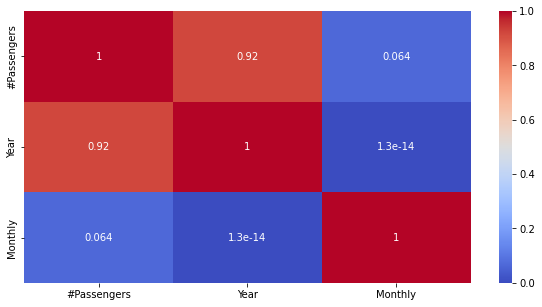

In [102]:
import seaborn as sns
plt.figure(figsize = (10,5))
sns.heatmap(data.corr(),annot = True , cmap = 'coolwarm' );

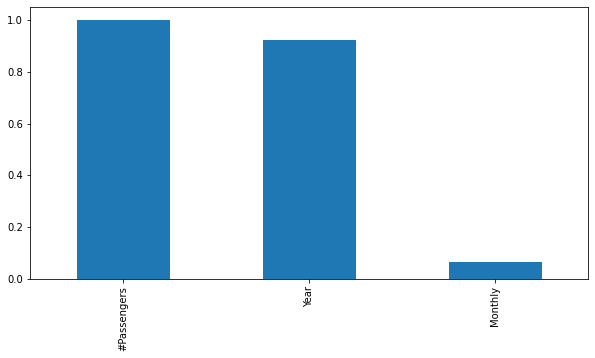

In [103]:
corr_mat = data.corr()
plt.figure(figsize = (10,5))
corr_mat['#Passengers'].sort_values(ascending = False).plot(kind = 'bar');

In [104]:
data.corr()['#Passengers'].sort_values(ascending=False).abs()

#Passengers    1.000000
Year           0.921824
Monthly        0.063649
Name: #Passengers, dtype: float64

In [105]:
from sklearn import preprocessing
columns = data.columns
for i in columns:
    if data.dtypes[i] is object:
        print("Cannot process object data")
    

## if skew is 0.5 and -0.5 i.e its normal distribution and use scaler else normalise
scale_list = []
normalise_list = []
data_skew = data.skew()

for i in columns:
    if data_skew[i] >= -0.5 and data_skew[i] <= 0.5:
        scale_list.append(i)
    else:
        normalise_list.append(i)
print(scale_list)
print(normalise_list)

['Year', 'Monthly']
['#Passengers']


In [106]:
df = data.copy(deep=True)
df

,#Passengers,Year,Monthly
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5
...,...,...,...
1960-08-01,606,1960,8
1960-09-01,508,1960,9
1960-10-01,461,1960,10


In [107]:
col_names = ['Year','Monthly']
features = df[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df[col_names] = features
print(data)

            #Passengers  Year  Monthly
Month                                 
1949-01-01          112  1949        1
1949-02-01          118  1949        2
1949-03-01          132  1949        3
1949-04-01          129  1949        4
1949-05-01          121  1949        5
...                 ...   ...      ...
1960-08-01          606  1960        8
1960-09-01          508  1960        9
1960-10-01          461  1960       10
1960-11-01          390  1960       11
1960-12-01          432  1960       12

[144 rows x 3 columns]


In [108]:
col_names = ['#Passengers']
features = df[col_names]
scaler_1 = preprocessing.MinMaxScaler().fit(features.values)
features = scaler_1.transform(features.values)
df[col_names] = features
print(data)

            #Passengers  Year  Monthly
Month                                 
1949-01-01          112  1949        1
1949-02-01          118  1949        2
1949-03-01          132  1949        3
1949-04-01          129  1949        4
1949-05-01          121  1949        5
...                 ...   ...      ...
1960-08-01          606  1960        8
1960-09-01          508  1960        9
1960-10-01          461  1960       10
1960-11-01          390  1960       11
1960-12-01          432  1960       12

[144 rows x 3 columns]


In [109]:
print(df)

            #Passengers      Year   Monthly
Month                                      
1949-01-01     0.015444 -1.593255 -1.593255
1949-02-01     0.027027 -1.593255 -1.303572
1949-03-01     0.054054 -1.593255 -1.013890
1949-04-01     0.048263 -1.593255 -0.724207
1949-05-01     0.032819 -1.593255 -0.434524
...                 ...       ...       ...
1960-08-01     0.969112  1.593255  0.434524
1960-09-01     0.779923  1.593255  0.724207
1960-10-01     0.689189  1.593255  1.013890
1960-11-01     0.552124  1.593255  1.303572
1960-12-01     0.633205  1.593255  1.593255

[144 rows x 3 columns]


In [110]:
test_split=round(len(df)*0.20)


In [111]:
df_for_training=df[:-36]
df_for_testing=df[-36:]
print(df_for_training.shape)
print(df_for_testing.shape)

(108, 3)
(36, 3)


In [112]:
'''col_list = list(train_data)
# use this handy way to swap the elements
col_list[0], col_list[1] = col_list[1], col_list[0]
# assign back, the order will now be swapped
train_data.columns = col_list
train_data'''

'col_list = list(train_data)\n# use this handy way to swap the elements\ncol_list[0], col_list[1] = col_list[1], col_list[0]\n# assign back, the order will now be swapped\ntrain_data.columns = col_list\ntrain_data'

In [113]:
'''col_list = list(train_data)
# use this handy way to swap the elements
col_list[1], col_list[2] = col_list[2], col_list[1]
# assign back, the order will now be swapped
train_data.columns = col_list
train_data'''

'col_list = list(train_data)\n# use this handy way to swap the elements\ncol_list[1], col_list[2] = col_list[2], col_list[1]\n# assign back, the order will now be swapped\ntrain_data.columns = col_list\ntrain_data'

In [114]:
train_data_1 = df_for_training.to_numpy()
test_data_1 = df_for_testing.to_numpy()

print(train_data_1)
print(test_data_1)


[[ 0.01544402 -1.59325501 -1.59325501]
 [ 0.02702703 -1.59325501 -1.30357228]
 [ 0.05405405 -1.59325501 -1.01388955]
 [ 0.04826255 -1.59325501 -0.72420682]
 [ 0.03281853 -1.59325501 -0.43452409]
 [ 0.05984556 -1.59325501 -0.14484136]
 [ 0.08494208 -1.59325501  0.14484136]
 [ 0.08494208 -1.59325501  0.43452409]
 [ 0.06177606 -1.59325501  0.72420682]
 [ 0.02895753 -1.59325501  1.01388955]
 [ 0.         -1.59325501  1.30357228]
 [ 0.02702703 -1.59325501  1.59325501]
 [ 0.02123552 -1.30357228 -1.59325501]
 [ 0.04247104 -1.30357228 -1.30357228]
 [ 0.07142857 -1.30357228 -1.01388955]
 [ 0.05984556 -1.30357228 -0.72420682]
 [ 0.04054054 -1.30357228 -0.43452409]
 [ 0.08687259 -1.30357228 -0.14484136]
 [ 0.12741313 -1.30357228  0.14484136]
 [ 0.12741313 -1.30357228  0.43452409]
 [ 0.1042471  -1.30357228  0.72420682]
 [ 0.05598456 -1.30357228  1.01388955]
 [ 0.01930502 -1.30357228  1.30357228]
 [ 0.06949807 -1.30357228  1.59325501]
 [ 0.07915058 -1.01388955 -1.59325501]
 [ 0.08880309 -1.01388955

In [115]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(train_data_1,12)
testX,testY=createXY(test_data_1,12)

In [116]:
'''trainX = []
trainY = []

n_future = 1   # Number of month we want to look into the future based on the past days.
n_past = 12  # Number of past months we want to use to predict the future.

#Reformat input data into a shawpe: (n_samples x timesteps x n_features)
#In my example, my train_data has a shape (132, 3)
#132 refers to the number of data points and 3 refers to the columns (multi-variables).
for i in range(n_past, len(train_data) - n_future + 1):
    trainX.append(train_data_1[i - n_past:i, 0:train_data.shape[1]])
    trainY.append(train_data_1[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))'''

"trainX = []\ntrainY = []\n\nn_future = 1   # Number of month we want to look into the future based on the past days.\nn_past = 12  # Number of past months we want to use to predict the future.\n\n#Reformat input data into a shawpe: (n_samples x timesteps x n_features)\n#In my example, my train_data has a shape (132, 3)\n#132 refers to the number of data points and 3 refers to the columns (multi-variables).\nfor i in range(n_past, len(train_data) - n_future + 1):\n    trainX.append(train_data_1[i - n_past:i, 0:train_data.shape[1]])\n    trainY.append(train_data_1[i + n_future - 1:i + n_future, 0])\n\ntrainX, trainY = np.array(trainX), np.array(trainY)\n\nprint('trainX shape == {}.'.format(trainX.shape))\nprint('trainY shape == {}.'.format(trainY.shape))"

In [117]:
'''testX = []
testY = []

n_future = 1   # Number of month we want to look into the future based on the past days.
n_past = 1  # Number of past months we want to use to predict the future.

#Reformat input data into a shawpe: (n_samples x timesteps x n_features)
#In my example, my train_data has a shape (132, 3)
#132 refers to the number of data points and 3 refers to the columns (multi-variables).
for i in range(n_past, len(dfCopy) - n_future + 1):
    testX.append(dfCopy[i - n_past:i, 0:dfCopy.shape[1]])
    testY.append(dfCopy[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))'''

"testX = []\ntestY = []\n\nn_future = 1   # Number of month we want to look into the future based on the past days.\nn_past = 1  # Number of past months we want to use to predict the future.\n\n#Reformat input data into a shawpe: (n_samples x timesteps x n_features)\n#In my example, my train_data has a shape (132, 3)\n#132 refers to the number of data points and 3 refers to the columns (multi-variables).\nfor i in range(n_past, len(dfCopy) - n_future + 1):\n    testX.append(dfCopy[i - n_past:i, 0:dfCopy.shape[1]])\n    testY.append(dfCopy[i + n_future - 1:i + n_future, 0])\n\ntestX, testY = np.array(testX), np.array(testY)\n\nprint('testX shape == {}.'.format(testX.shape))\nprint('testY shape == {}.'.format(testY.shape))"

In [118]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)



print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)



trainX Shape--  (96, 12, 3)
trainY Shape--  (96,)
testX Shape--  (24, 12, 3)
testY Shape--  (24,)


In [119]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[ 0.01544402 -1.59325501 -1.59325501]
 [ 0.02702703 -1.59325501 -1.30357228]
 [ 0.05405405 -1.59325501 -1.01388955]
 [ 0.04826255 -1.59325501 -0.72420682]
 [ 0.03281853 -1.59325501 -0.43452409]
 [ 0.05984556 -1.59325501 -0.14484136]
 [ 0.08494208 -1.59325501  0.14484136]
 [ 0.08494208 -1.59325501  0.43452409]
 [ 0.06177606 -1.59325501  0.72420682]
 [ 0.02895753 -1.59325501  1.01388955]
 [ 0.         -1.59325501  1.30357228]
 [ 0.02702703 -1.59325501  1.59325501]]
trainY[0]--  0.02123552123552122


In [120]:
from keras.wrappers.scikit_learn import KerasRegressor

def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(12,3)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [121]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/8
3/3 [==============================] - 3s 335ms/step - loss: 0.0923 - val_loss: 0.0930
Epoch 2/8
3/3 [==============================] - 0s 24ms/step - loss: 0.0361 - val_loss: 0.0164
Epoch 3/8
3/3 [==============================] - 0s 21ms/step - loss: 0.0092 - val_loss: 0.0995
Epoch 4/8
3/3 [==============================] - 0s 19ms/step - loss: 0.0164 - val_loss: 0.0779
Epoch 5/8
3/3 [==============================] - 0s 19ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 6/8
3/3 [==============================] - 0s 18ms/step - loss: 0.0076 - val_loss: 0.0199
Epoch 7/8
3/3 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 0.0339
Epoch 8/8
3/3 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 1/8
3/3 [==============================] - 3s 375ms/step - loss: 0.0380 - val_loss: 0.5659
Epoch 2/8
3/3 [==============================] - 0s 18ms/step - loss: 0.0137 - val_loss: 0.6429
Epoch 3/8
3/3 [==============================] - 0s 19ms/s

In [122]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}

In [123]:
my_model=grid_search.best_estimator_.model

In [124]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

1/1 [==============================] - 1s 556ms/step
prediction
 [[0.46670726]
 [0.5072947 ]
 [0.5602424 ]
 [0.6093893 ]
 [0.6470158 ]
 [0.6686419 ]
 [0.6732005 ]
 [0.6661123 ]
 [0.6512079 ]
 [0.6313842 ]
 [0.60402393]
 [0.5716441 ]
 [0.53778344]
 [0.58333987]
 [0.6389496 ]
 [0.68696886]
 [0.72398233]
 [0.744589  ]
 [0.74974066]
 [0.74301857]
 [0.7278479 ]
 [0.7067321 ]
 [0.6785153 ]
 [0.6436174 ]]

Prediction Shape- (24, 1)


In [126]:
pred = scaler_1.inverse_transform(prediction)[:,0]

In [127]:
pred

array([345.75436, 366.7787 , 394.2056 , 419.66367, 439.1542 , 450.35654,
       452.71786, 449.04617, 441.3257 , 431.05704, 416.8844 , 400.11166,
       382.57184, 406.17007, 434.9759 , 459.84988, 479.02286, 489.6971 ,
       492.36566, 488.88364, 481.0252 , 470.08725, 455.47095, 437.39383],
      dtype=float32)

In [129]:
testY

array([0.49420849, 0.45945946, 0.58301158, 0.56370656, 0.61003861,
       0.71042471, 0.85714286, 0.87837838, 0.69305019, 0.58494208,
       0.4980695 , 0.58108108, 0.6042471 , 0.55405405, 0.60810811,
       0.68918919, 0.71042471, 0.83204633, 1.        , 0.96911197,
       0.77992278, 0.68918919, 0.55212355, 0.63320463])

In [131]:
testY = np.reshape(testY, (-1, 1))
testY

array([[0.49420849],
       [0.45945946],
       [0.58301158],
       [0.56370656],
       [0.61003861],
       [0.71042471],
       [0.85714286],
       [0.87837838],
       [0.69305019],
       [0.58494208],
       [0.4980695 ],
       [0.58108108],
       [0.6042471 ],
       [0.55405405],
       [0.60810811],
       [0.68918919],
       [0.71042471],
       [0.83204633],
       [1.        ],
       [0.96911197],
       [0.77992278],
       [0.68918919],
       [0.55212355],
       [0.63320463]])

In [132]:
orig = scaler_1.inverse_transform(testY)
orig

array([[360.],
       [342.],
       [406.],
       [396.],
       [420.],
       [472.],
       [548.],
       [559.],
       [463.],
       [407.],
       [362.],
       [405.],
       [417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.],
       [432.]])

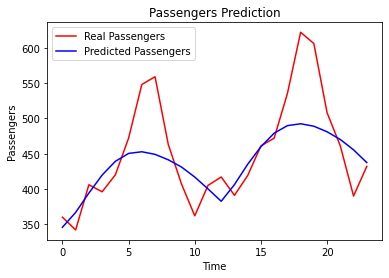

In [133]:
plt.plot(orig, color = 'red', label = 'Real Passengers')
plt.plot(pred, color = 'blue', label = 'Predicted Passengers')
plt.title('Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [134]:
mape = np.mean(np.abs((orig - pred) / orig)) * 100
print(mape)

14.478854079207812


In [145]:
'''model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))'''

"model = Sequential()\nmodel.add(LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))\nmodel.add(LSTM(32, activation='relu', return_sequences=False))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(trainY.shape[1]))"

In [146]:
'''model.compile(optimizer='adam', loss='mse')
model.summary()'''

"model.compile(optimizer='adam', loss='mse')\nmodel.summary()"

In [147]:
'''history = model.fit(trainX, trainY, epochs=49, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()'''

"history = model.fit(trainX, trainY, epochs=49, batch_size=16, validation_split=0.1, verbose=1)\n\nplt.plot(history.history['loss'], label='Training loss')\nplt.plot(history.history['val_loss'], label='Validation loss')\nplt.legend()"

In [148]:
'''#EArly stop
n_future = 12
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods = n_future,freq='1m').tolist()'''

"#EArly stop\nn_future = 12\nforecast_period_dates = pd.date_range(list(train_dates)[-1], periods = n_future,freq='1m').tolist()"

In [149]:
'''print(forecast_period_dates)'''

'print(forecast_period_dates)'

In [150]:

#forecast = model.predict(trainX[-n_future:])
'''forecast = model.predict(testX)  '''

'forecast = model.predict(testX)  '

In [151]:
'''print(forecast)'''

'print(forecast)'

In [130]:
'''prediction_copies = np.repeat(forecast, 2, axis=-1)
print(prediction_copies)'''


'prediction_copies = np.repeat(forecast, 2, axis=-1)\nprint(prediction_copies)'

In [152]:
'''y_pred_future = scaler_1.inverse_transform(forecast)[:,0]
y_pred_future'''

'y_pred_future = scaler_1.inverse_transform(forecast)[:,0]\ny_pred_future'

In [153]:
'''forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())'''

'forecast_dates = []\nfor time_i in forecast_period_dates:\n    forecast_dates.append(time_i.date())'

In [154]:
'''forecast_dates'''

'forecast_dates'

In [155]:
'''df_forecast = pd.DataFrame({'Month':np.array(forecast_dates), '#Passengers':y_pred_future})
df_forecast['Month']=pd.to_datetime(df_forecast['Month'])'''

"df_forecast = pd.DataFrame({'Month':np.array(forecast_dates), '#Passengers':y_pred_future})\ndf_forecast['Month']=pd.to_datetime(df_forecast['Month'])"

In [156]:
'''df_forecast'''

'df_forecast'

In [157]:
'''test_data'''

'test_data'

In [158]:
'''y = test_data['#Passengers']
Y = df_forecast['#Passengers']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)'''

"y = test_data['#Passengers']\nY = df_forecast['#Passengers']\ny_true, Y_pred = np.array(y), np.array(Y)\nmape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100\nprint(mape)"

In [159]:

'''test_data = test_data.rename(index = lambda x: x - 132)
test_data'''

'test_data = test_data.rename(index = lambda x: x - 132)\ntest_data'

In [160]:
'''orig = plt.plot(test_data['#Passengers'], color='blue', label='Original')
predicted = plt.plot(df_forecast['#Passengers'], color='red', label='Predicted')
plt.show()'''

"orig = plt.plot(test_data['#Passengers'], color='blue', label='Original')\npredicted = plt.plot(df_forecast['#Passengers'], color='red', label='Predicted')\nplt.show()"

In [161]:
'''import math
from keras.layers import  Flatten
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D'''

'import math\nfrom keras.layers import  Flatten\nfrom sklearn.metrics import mean_squared_error\n#from keras.callbacks import EarlyStopping\nfrom keras.layers import ConvLSTM2D'

In [162]:
'''data = pd.read_csv("AirPassengers.csv")
data.head()'''

'data = pd.read_csv("AirPassengers.csv")\ndata.head()'

In [163]:
'''dataframe = pd.read_csv('AirPassengers.csv', usecols=[1])
plt.plot(dataframe)'''

"dataframe = pd.read_csv('AirPassengers.csv', usecols=[1])\nplt.plot(dataframe)"

In [164]:
'''dataframe'''

'dataframe'

In [165]:
'''train_data = dataframe[:len(data)-12]
print(train_data)
test_data = dataframe[len(data)-12:]
print(test_data.shape)
test_data'''

'train_data = dataframe[:len(data)-12]\nprint(train_data)\ntest_data = dataframe[len(data)-12:]\nprint(test_data.shape)\ntest_data'

In [145]:
col_names = ['#Passengers']
features = train_data[col_names]
scaler = preprocessing.MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
train_data[col_names] = features
print(train_data)

     #Passengers
0       0.017582
1       0.030769
2       0.061538
3       0.054945
4       0.037363
..           ...
127     1.000000
128     0.789011
129     0.665934
130     0.567033
131     0.661538

[132 rows x 1 columns]


In [146]:
dataset = train_data.values

In [147]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [148]:
seq_size = 10

In [149]:
trainX, trainY = to_sequences(dataset, seq_size)

In [150]:
print("Shape of training set: {}".format(trainX.shape))

Shape of training set: (121, 10)


In [151]:
trainX

array([[0.01758242, 0.03076923, 0.06153846, ..., 0.0967033 , 0.07032967,
        0.03296703],
       [0.03076923, 0.06153846, 0.05494505, ..., 0.07032967, 0.03296703,
        0.        ],
       [0.06153846, 0.05494505, 0.03736264, ..., 0.03296703, 0.        ,
        0.03076923],
       ...,
       [0.45274725, 0.51208791, 0.56263736, ..., 0.80879121, 0.97582418,
        1.        ],
       [0.51208791, 0.56263736, 0.52307692, ..., 0.97582418, 1.        ,
        0.78901099],
       [0.56263736, 0.52307692, 0.66373626, ..., 1.        , 0.78901099,
        0.66593407]])

In [152]:
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))

In [153]:
trainX.shape

(121, 1, 1, 1, 10)

In [154]:
#trainX shape == (120, 12, 3).
print("Shape of training set: {}".format(trainY.shape))

Shape of training set: (121,)


In [155]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 2s 41ms/step - loss: 0.1324 - val_loss: 0.3094
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0628 - val_loss: 0.1327
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0204 - val_loss: 0.0397
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0271
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0185 - val_loss: 0.0273
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0349
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0377
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0297
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0250
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0239
Epoch 11/100
7/7 [==========

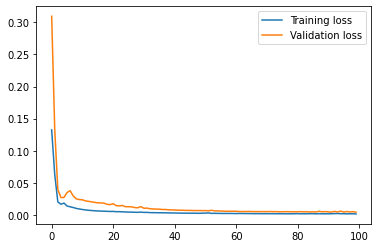

In [156]:
#history = model.fit(trainX, trainY, epochs=49, batch_size=16, validation_split=0.1, verbose=1)
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [157]:
n_future = 12


In [158]:
forecast = model.predict(trainX[-n_future:]) 

1/1 [==============================] - 0s 175ms/step


In [159]:
print(forecast)

[[0.46041194]
 [0.57191086]
 [0.5608379 ]
 [0.52401185]
 [0.66904396]
 [0.7274877 ]
 [0.9073192 ]
 [0.8699142 ]
 [0.96255153]
 [0.8687952 ]
 [0.63721514]
 [0.5403504 ]]


In [160]:
y_pred_future = scaler.inverse_transform(forecast)[:,0]
y_pred_future

array([313.48743, 364.21942, 359.18124, 342.42538, 408.415  , 435.0069 ,
       516.8302 , 499.81094, 541.961  , 499.30185, 393.9329 , 349.8594 ],
      dtype=float32)

In [161]:
df_forecast = pd.DataFrame({'#Passengers':y_pred_future})

In [162]:
df_forecast

,#Passengers
0,313.487427
1,364.219421
2,359.181244
3,342.425385
4,408.415009
5,435.006897
6,516.830200
7,499.810944
8,541.960999
9,499.301849


In [163]:
y = test_data['#Passengers']
Y = df_forecast['#Passengers']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)

14.439936124091544


In [164]:
test_data = test_data.rename(index = lambda x: x - 132)
test_data

,#Passengers
0,417
1,391
2,419
3,461
4,472
5,535
6,622
7,606
8,508
9,461


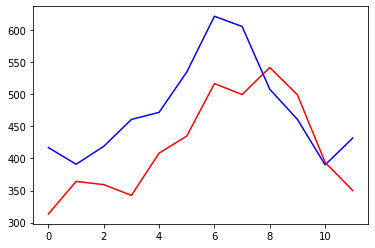

In [165]:
orig = plt.plot(test_data['#Passengers'], color='blue', label='Original')
predicted = plt.plot(df_forecast['#Passengers'], color='red', label='Predicted')
plt.show()